In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score


# Carga y Exploración de los Datos

In [2]:
# Cargar los datos desde los archivos proporcionados
train_data = pd.read_csv('https://docs.google.com/spreadsheets/d/1tdZHFY3JzNXUg3PZO6A7txKFhMyNvchqxEi72W-2X0k/gviz/tq?tqx=out:csv&sheet=Sheet1')
test_data = pd.read_csv('https://docs.google.com/spreadsheets/d/1jjKaIwOcf5ZAEnt1zkDUX3ORjMhInk__PAsPfxBnLFI/gviz/tq?tqx=out:csv&sheet=Sheet1')

# Convertir la columna 'date' a datetime y extraer características numéricas si es necesario
train_data['date'] = pd.to_datetime(train_data['date'])
# Ejemplo: extraer el mes como una característica numérica
train_data['month'] = train_data['date'].dt.month

# Exploración inicial de los datos
print(train_data.head())
print(train_data.info())
print(train_data.describe())


        date   meantemp   humidity  wind_speed  meanpressure  month
0 2017-01-01  15.913043  85.869565    2.743478     59.000000      1
1 2017-01-02  18.500000  77.222222    2.894444   1018.277778      1
2 2017-01-03  17.111111  81.888889    4.016667   1018.333333      1
3 2017-01-04  18.700000  70.050000    4.545000   1015.700000      1
4 2017-01-05  18.388889  74.944444    3.300000   1014.333333      1
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          114 non-null    datetime64[ns]
 1   meantemp      114 non-null    float64       
 2   humidity      114 non-null    float64       
 3   wind_speed    114 non-null    float64       
 4   meanpressure  114 non-null    float64       
 5   month         114 non-null    int32         
dtypes: datetime64[ns](1), float64(4), int32(1)
memory usage: 5.0 KB
None
              

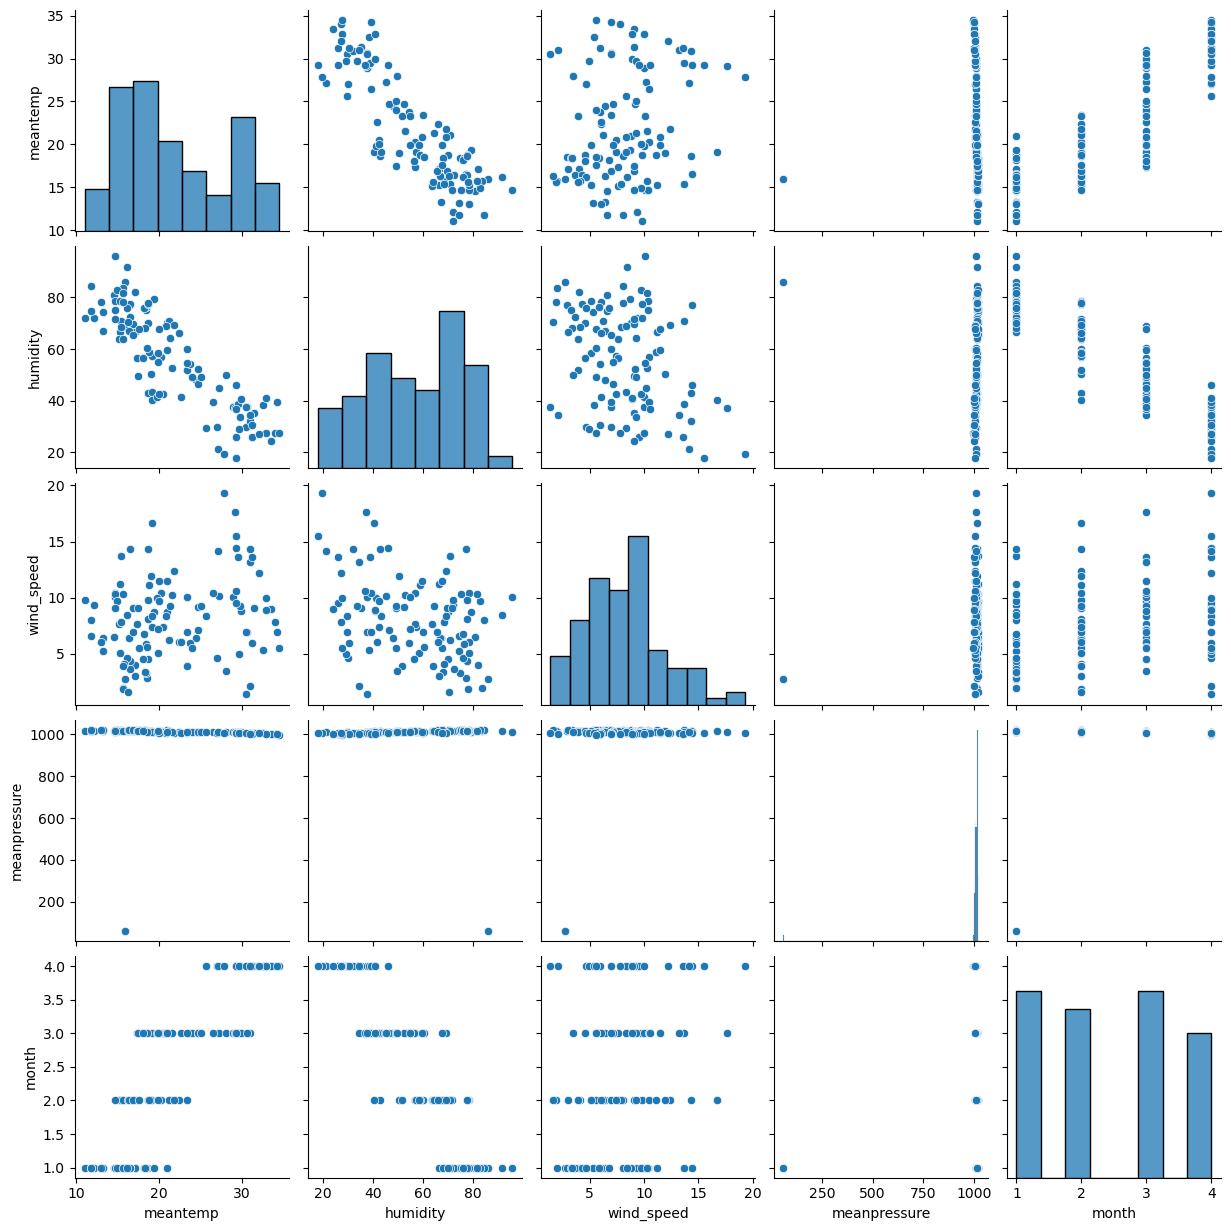

In [3]:
# Visualización inicial de la distribución de las variables
sns.pairplot(train_data.drop('date', axis=1))
plt.show()

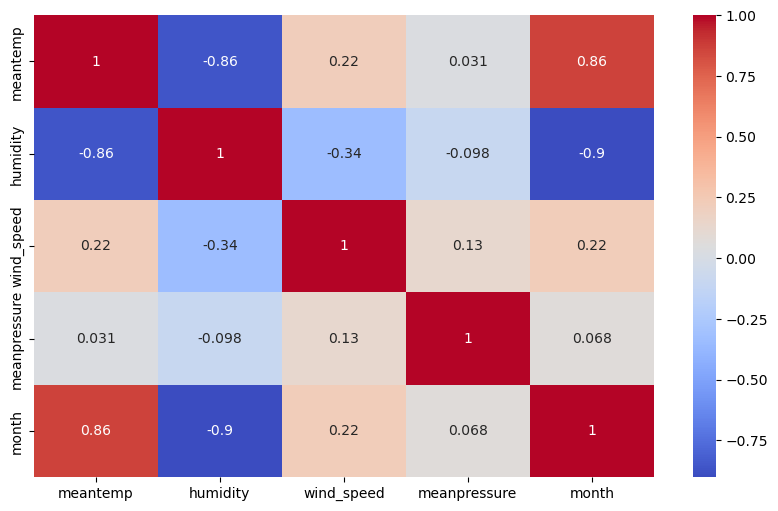

In [4]:
# Correlación entre las variables (excluyendo 'date')
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.drop('date', axis=1).corr(), annot=True, cmap='coolwarm')
plt.show()

# Preprocesamiento de Datos

In [5]:
# Imputar valores nulos con la media para columnas numéricas solamente
numeric_columns_train = train_data.select_dtypes(include=np.number).columns
train_data[numeric_columns_train] = train_data[numeric_columns_train].fillna(train_data[numeric_columns_train].mean())

numeric_columns_test = test_data.select_dtypes(include=np.number).columns
test_data[numeric_columns_test] = test_data[numeric_columns_test].fillna(test_data[numeric_columns_test].mean())

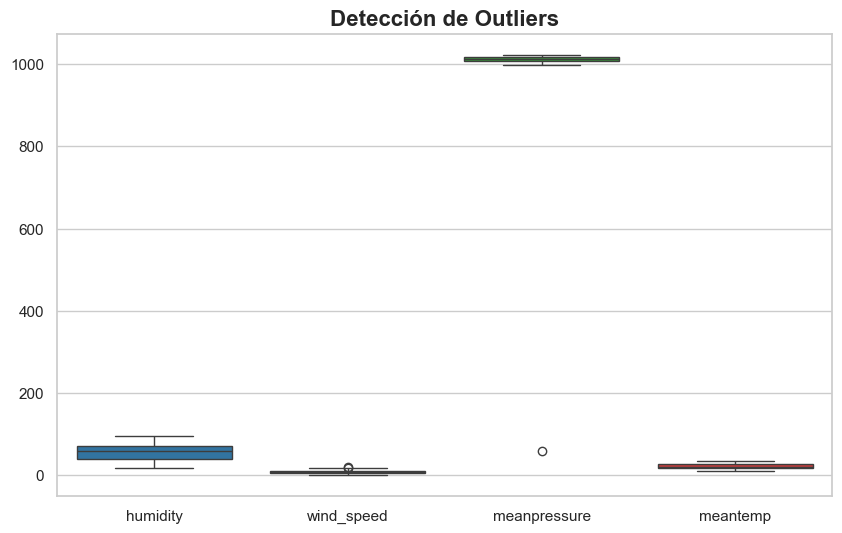

In [6]:
# Estilo y configuración de colores
sns.set(style="whitegrid", palette="pastel")

# Visualización de outliers usando diagramas de caja
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data[['humidity', 'wind_speed', 'meanpressure', 'meantemp']],
            palette=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
plt.title('Detección de Outliers', fontsize=16, fontweight='bold')
plt.show()

In [7]:
# Separar características y variable objetivo
X_train = train_data[['humidity', 'wind_speed', 'meanpressure']]
y_train = train_data['meantemp']

X_test = test_data[['humidity', 'wind_speed', 'meanpressure']]
y_test = test_data['meantemp']

# Estandarización de las características
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [8]:
# Crear nuevas características: Interacciones, polinomios de segundo grado, etc.
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Actualizar las características a utilizar
X_train = pd.DataFrame(X_train_poly, columns=poly.get_feature_names_out())
X_test = pd.DataFrame(X_test_poly, columns=poly.get_feature_names_out())


# Análisis Exploratorio de Datos (EDA) Avanzado

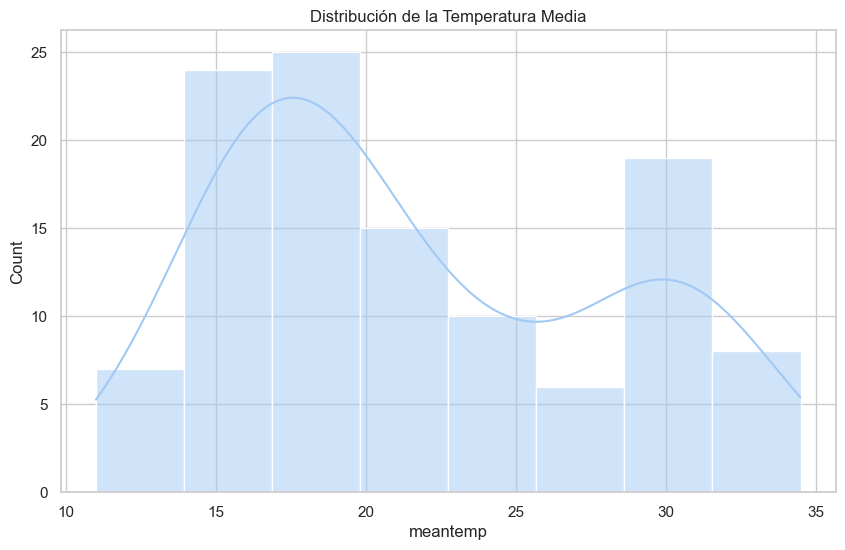

In [9]:
# Visualización de la distribución de la variable objetivo
plt.figure(figsize=(10, 6))
sns.histplot(train_data['meantemp'], kde=True)
plt.title('Distribución de la Temperatura Media')
plt.show()


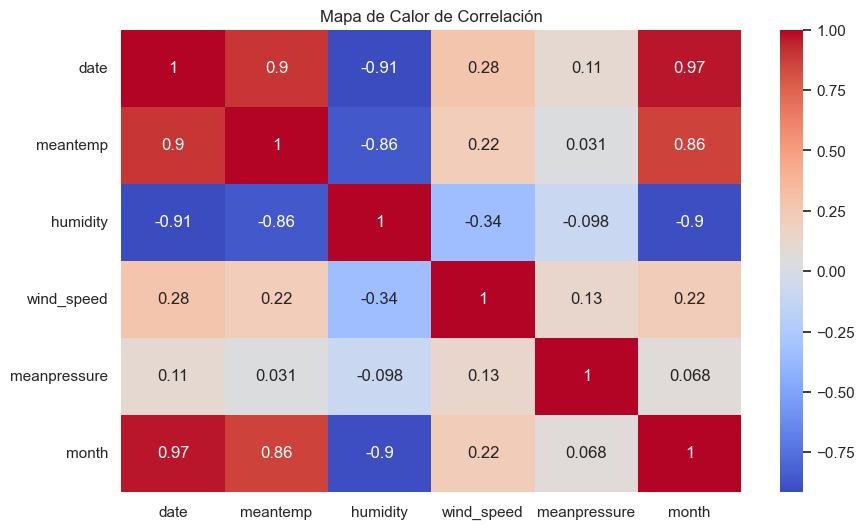

In [10]:
# Correlación entre las variables
plt.figure(figsize=(10, 6))
sns.heatmap(train_data.corr(), annot=True, cmap='coolwarm')
plt.title('Mapa de Calor de Correlación')
plt.show()


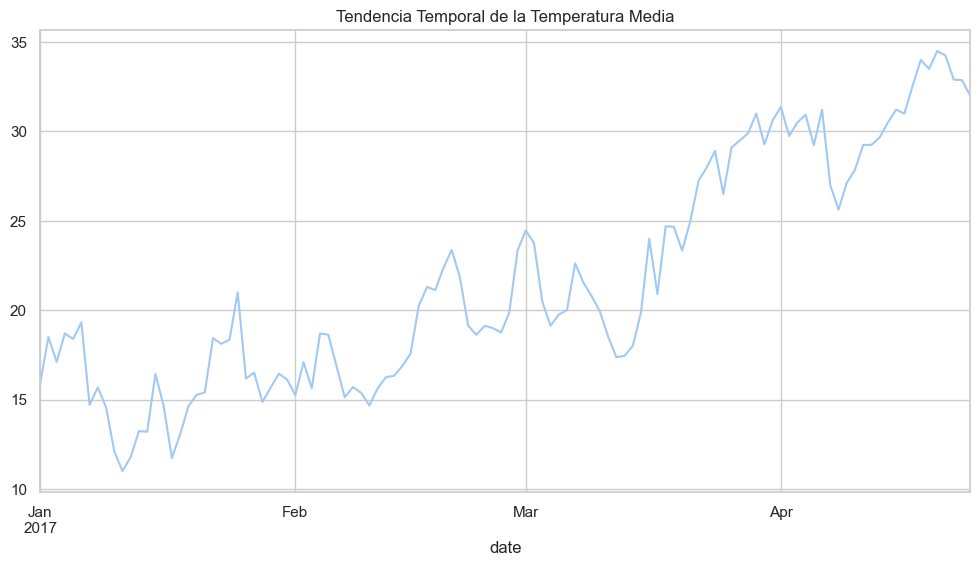

In [11]:
# Convertir fecha a tipo datetime y analizar tendencias
train_data['date'] = pd.to_datetime(train_data['date'])
train_data.set_index('date', inplace=True)

plt.figure(figsize=(12, 6))
train_data['meantemp'].plot()
plt.title('Tendencia Temporal de la Temperatura Media')
plt.show()


# Selección y Optimización del Modelo

In [12]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'MSE': mse, 'R²': r2}

results_df = pd.DataFrame(results).T
print(results_df)


                            MSE           R²
Linear Regression  56940.962589 -1054.289272
Ridge Regression     729.153346   -12.513430
Lasso Regression      59.775035    -0.107813
Decision Tree         37.003261     0.314217
Random Forest         31.722428     0.412087
Gradient Boosting     34.790305     0.355230


In [13]:
# Validación cruzada para un modelo específico
cross_val_scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42), X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cross_val_mse = -cross_val_scores.mean()
print(f'Cross-Validated MSE: {cross_val_mse}')


Cross-Validated MSE: 11.573414976428783


In [14]:
# Ejemplo de GridSearchCV para Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f'Mejor modelo: {best_model}')


Mejor modelo: RandomForestRegressor(min_samples_split=5, n_estimators=50, random_state=42)


# Entrenamiento y Evaluación del Modelo

In [17]:
# Entrenar el mejor modelo encontrado
best_model.fit(X_train, y_train)
y_pred_best = best_model.predict(X_test)

# Evaluación
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

print(f'MSE del Mejor Modelo: {mse_best}')
print(f'R² del Mejor Modelo: {r2_best}')


MSE del Mejor Modelo: 31.444917297044114
R² del Mejor Modelo: 0.4172300154585574


# Análisis de Resultados

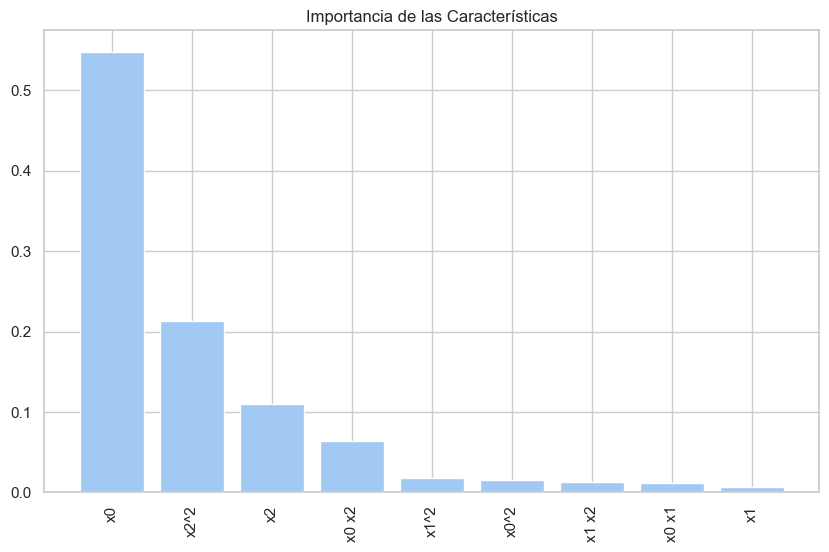

In [18]:
# Importancia de características para Random Forest o cualquier modelo con feature_importances_
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title('Importancia de las Características')
plt.bar(range(X_train.shape[1]), importances[indices], align='center')
plt.xticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices], rotation=90)
plt.show()


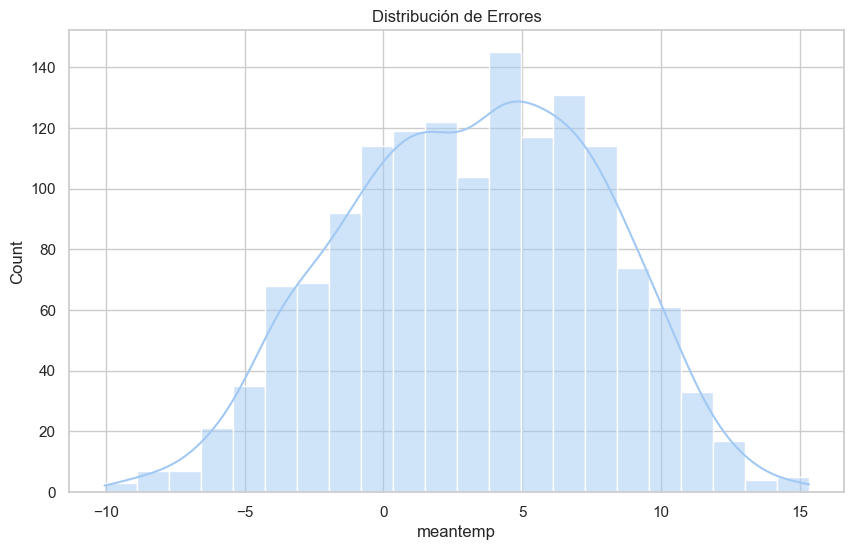

In [19]:
# Análisis de errores
errors = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True)
plt.title('Distribución de Errores')
plt.show()


In [20]:
# Comparar los resultados de diferentes modelos
print(results_df.sort_values(by='MSE'))


                            MSE           R²
Random Forest         31.722428     0.412087
Gradient Boosting     34.790305     0.355230
Decision Tree         37.003261     0.314217
Lasso Regression      59.775035    -0.107813
Ridge Regression     729.153346   -12.513430
Linear Regression  56940.962589 -1054.289272


# Visualización Avanzada de Resultados

Text(0.5, 1.0, 'Predicciones vs Valores Reales')

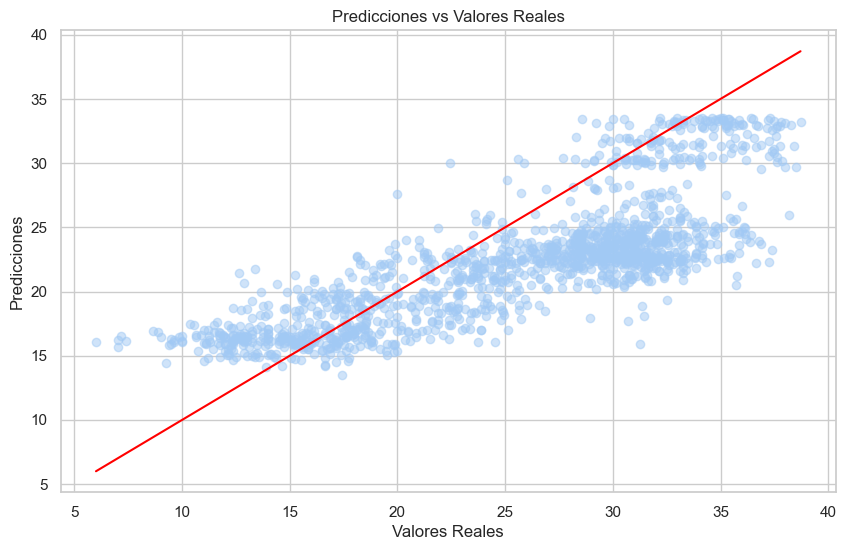

In [21]:
# Gráfico de dispersión de predicciones vs valores reales para el mejor modelo
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Línea de identidad
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Predicciones vs Valores Reales')
